In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from src.estimate import sbm_slow, sbm_fast

---
### Example

In [2]:
rng = np.random.default_rng(0)
probs = np.array([
    [0.4, 0.4, 0.01],
    [0.4, 0., 0.01],
    [0.01, 0.01, 0.42],
])
sizes = rng.poisson(111, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]

In [3]:
pred, scores = sbm_fast(graph, 3, alpha=0.1, tol=0.01, track_scores=True)

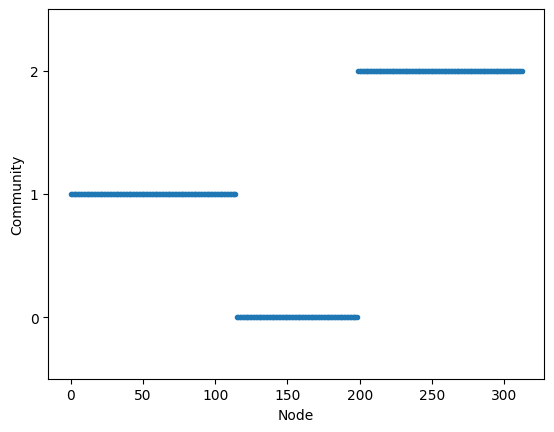

In [4]:
plt.plot(pred, '.')
plt.yticks([0, 1, 2])
plt.ylabel('Community')
plt.ylim([-0.5, 2.5])
plt.xlabel('Node')
plt.show()

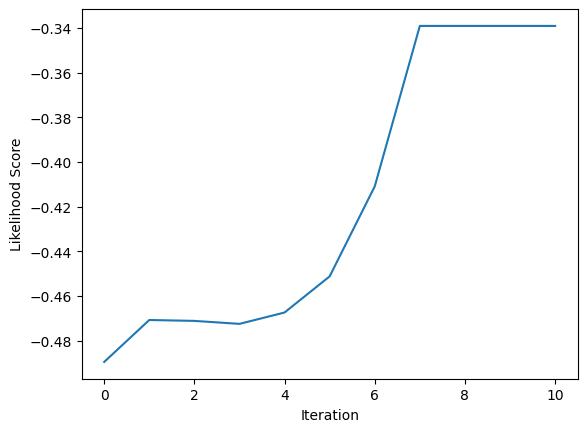

In [5]:
plt.plot(scores)
plt.ylabel('Likelihood Score')
plt.xlabel('Iteration')
plt.show()

---
### Profiling

In [10]:
rng = np.random.default_rng(0)
probs = np.array([
    [0.2, 0.01, 0.01],
    [0.01, 0.2, 0.01],
    [0.01, 0.01, 0.2],
])
sizes = rng.poisson(3000, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]

In [11]:
from src import estimate
estimate.VERBOSE = False
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [12]:
# %timeit sbm_fast(graph, 10, max_iter=100, tol=0, alpha=0.0001)
%timeit sbm_fast(graph, 3, max_iter=100, tol=0, alpha=0.0001)

5.55 s ± 78.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%memit sbm_fast(graph, 3, max_iter=100, tol=0, alpha=0.0001)

peak memory: 1847.42 MiB, increment: 316.19 MiB


In [14]:
# %timeit sbm_slow(graph, 10, max_iter=100, tol=0, alpha=0.0001)
%timeit sbm_slow(graph, 3, max_iter=100, tol=0, alpha=0.0001)

50.8 s ± 1.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%memit sbm_slow(graph, 3, max_iter=100, tol=0, alpha=0.0001)

peak memory: 4581.75 MiB, increment: 2974.28 MiB


In [16]:
np.random.seed(0)
seed = 123
np.random.seed(seed)
p1, t1 = sbm_slow(graph, 3, max_iter=100, track_scores=True, tol=0., alpha=0.0001)
np.random.seed(seed)
p2, t2 = sbm_fast(graph, 3, max_iter=100, track_scores=True, tol=0., alpha=0.0001)
np.abs(p1-p2).mean(), np.abs(t1-t2).mean()

(0.0, 1.3344660909850892e-15)

---
### Visualization

In [ ]:
import numpy as np
from src.estimate import *

def sbm_fast_drop(G, *,
                  min_size=3,
                  likelihood='bernoulli',
                  alpha=0.,
                  gamma=1.,
                  weight=None,
                  track_scores=False,
                  max_iter=100,
                  min_iter=10,
                  tol=0.01):

    track_scores = True

    ## Adjacency matrix ##
    A = nx.to_scipy_sparse_array(G, weight=weight).astype(float)
    n_nodes = len(G.nodes)
    n_comms = n_nodes // min_size

    if likelihood == 'bernoulli':
        assert ((A.data==0) | (A.data==1)).all()
    elif likelihood == 'poisson':
        assert (A.data >= 0).all() and (A.data == A.data.round()).all()
    elif likelihood == 'normal':
        pass
    else:
        raise ValueError

    ## Partition matrix ##
    Z_update = np.random.randn(n_nodes, n_comms)
    partition = Z_update.argmax(1)
    Z = csr_array((np.ones(n_nodes), (np.arange(n_nodes), partition)),
                  shape=(n_nodes, n_comms), dtype=float)

    ## Structure matrix sufficient statistics ##
    M = (Z.T @ (A @ Z)).toarray()
    n = Z.sum(0)[:, None]
    ## Structure matrix MLE ##
    B = M / (n@n.T).clip(1, None)

    ## Regularization ##
    R = np.eye(n_comms) * alpha

    A2 = None # elementwise square of A
    if track_scores:
        vprint('tracking scores may increase runtime')
        ## Initialize trace of scores ##
        if likelihood == 'bernoulli':
            L = M * clog(B) + (n@n.T - M) * clog(1-B)
        elif likelihood == 'poisson':
            L = M * clog(B) - (n@n.T) * B
        elif likelihood == 'normal':
            A2 = A.multiply(A)
            M2 = (Z.T @ (A2 @ Z)).toarray()
            L = -1/2 * (M2 - 2*B*M + (n@n.T) * B**2)
        trace = [L.sum()/n_nodes**2]

    history = []
    history.append((Z_update.copy(), Z.toarray().copy(), L.sum()/n_nodes**2))

    for epoch in range(max_iter):

        ## Compute predictions ##
        if likelihood == 'bernoulli':
            w_pre = 1 / (B * (1 - B)).clip(EPS, None)
        elif likelihood == 'poisson':
            w_pre = 1 / B.clip(EPS, None)
        elif likelihood == 'normal':
            w_pre = np.ones_like(B)
        w_block = (w_pre * n.T).sum(axis=1) / n.sum()
        w = w_block[partition]

        ## Compute gradients and hessian ##
        ZB = Z @ B
        ZBW = ZB * w[:, None]
        hess = ZB.T @ ZBW + R
        grad = (A.T @ ZBW).T

        ## Modify derivatives with entropy penalty ##
        p = Z.mean(0).clip(EPS, None)
        grad -= gamma * (np.log(p) + 1)[:, None]
        hess -= gamma * np.diag(1 / p)

        ## Perform Fisher scoring updates ##
        Z_update = np.linalg.solve(hess, grad).T

        ## Update partition ##
        prev_partition = partition
        partition = Z_update.argmax(1)

        ## Get rid of unused communities for stability ##
        mask = np.bincount(partition, minlength=n_comms) >= min_size
        if (~mask).any():
            Z_update = Z_update[:, mask]
            partition = Z_update.argmax(1)
            n_comms = Z_update.shape[1]
            R = np.eye(n_comms) * alpha
            Z = csr_array((np.ones(n_nodes), (np.arange(n_nodes), partition)),
                          shape=(n_nodes, n_comms), dtype=float)
        else:
            Z.indices[:] = partition
            Z.data[:] = 1

        ## Recompute structure matrix ##
        M = (Z.T @ (A @ Z)).toarray()
        n = Z.sum(0)[:, None]
        B = M / (n@n.T).clip(1, None)

        ## Early stopping ##
        if epoch >= min_iter and (prev_partition == partition).mean() > 1-tol:
            vprint('converged in', epoch+1, 'iterations')
            break

        ## Append current score to trace ##
        if track_scores:
            if likelihood == 'bernoulli':
                L = M * clog(B) + (n@n.T - M) * clog(1-B)
            elif likelihood == 'poisson':
                L = M * clog(B) - (n@n.T) * B
            elif likelihood == 'normal':
                M2 = (Z.T @ (A2 @ Z)).toarray()
                L = -1/2 * (M2 - 2*B*M + (n@n.T) * B**2)
            trace.append(L.sum()/n_nodes**2)
        history.append((Z_update.copy(), Z.toarray().copy(), L.sum()/n_nodes**2))

    else:
        vprint('did not converge after', max_iter, 'iterations')

    return history

In [18]:
rng = np.random.default_rng(0)
probs = np.array([
    [0.4, 0.01, 0.01],
    [0.01, 0.4, 0.01],
    [0.01, 0.01, 0.4],
])
sizes = rng.poisson(111, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]

In [19]:
history = sbm_fast_drop(graph, min_size=3, max_iter=10, alpha=0.1, tol=0.0)
history[-1][0].argmax(1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
X_hist = [h[0] for h in history]
Z_hist = [h[1] for h in history]
scores = [h[2] for h in history]
smin, smax = min(scores), max(scores)
srange = smax-smin
smin, smax = smin-(smax-smin)/10, smax+(smax-smin)/10

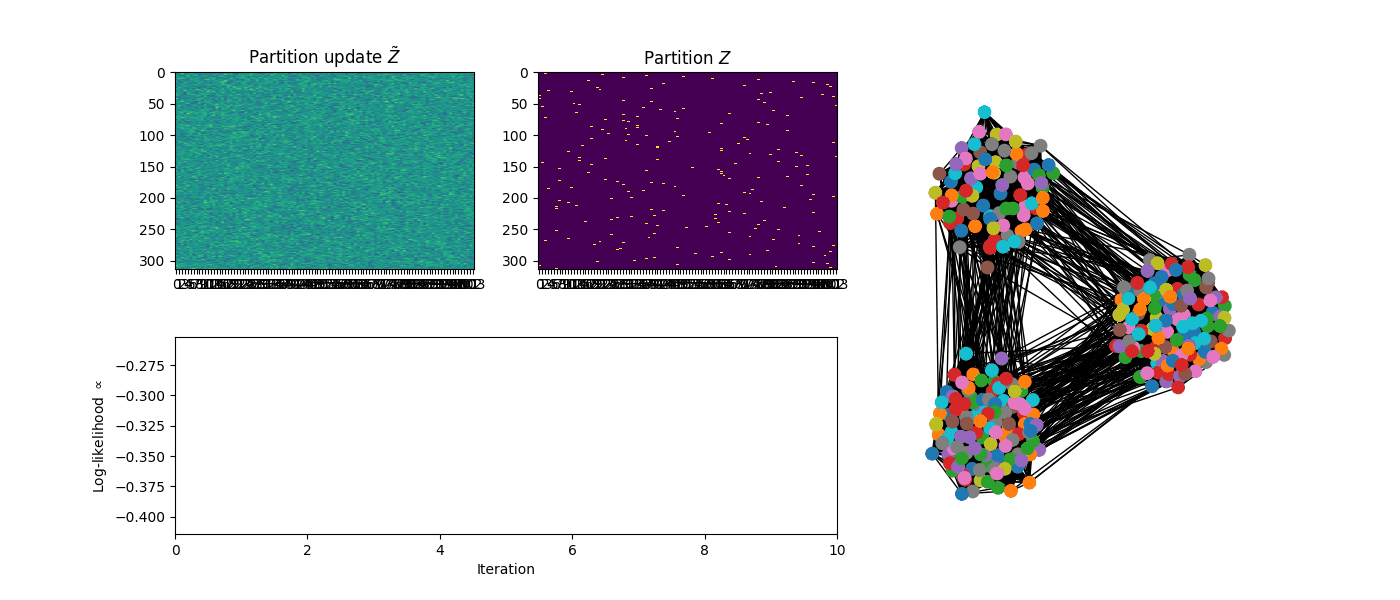

In [21]:
# ChatGPT:

from IPython.display import Image as IPImage
import numpy as np
import networkx as nx
from IPython.display import clear_output, display
from PIL import Image
import matplotlib.pyplot as plt

# Required variables from previous cells: X_hist, Z_hist, scores, graph
n_steps = len(X_hist)

# fixed layout for reproducibility; compute once
pos = nx.spring_layout(graph, seed=0)

# collect frames (RGB uint8 arrays)
frames = []

# single updating display using clear_output so only one figure is shown
for i in range(n_steps):
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1.2], height_ratios=[1, 1], hspace=0.35)

    # Left: top row has X and Z side-by-side
    ax_X = fig.add_subplot(gs[0, 0])
    ax_Y = fig.add_subplot(gs[0, 1])
    # Right: graph spans both rows
    ax_graph = fig.add_subplot(gs[:, 2])
    # Bottom: scores span left two columns
    ax_score = fig.add_subplot(gs[1, 0:2])

    # X and Z images for this step
    ax_X.imshow(X_hist[i], aspect='auto')
    ax_X.set_title(r'Partition update $\tilde{Z}$')
    ax_X.set_xticks(np.arange(X_hist[i].shape[1]))

    ax_Y.imshow(Z_hist[i], aspect='auto', interpolation='none')
    ax_Y.set_title(r'Partition $Z$')
    ax_Y.set_xticks(np.arange(Z_hist[i].shape[1]))

    # Scores up to this step
    xs = np.arange(i + 1)
    ys = np.array(scores[: i + 1])
    ax_score.plot(xs, ys, color='C1')
    ax_score.set_xlim(0, max(1, n_steps - 1))
    ax_score.set_ylim([smin, smax])
    ax_score.set_ylabel('Log-likelihood $\propto$')
    ax_score.set_xlabel('Iteration')

    # Graph colored by partition at this step
    partition = np.array(Z_hist[i]).argmax(1)
    nx.draw(graph, pos=pos, node_color=partition, cmap='tab10', ax=ax_graph, with_labels=False, node_size=80)

    # draw and capture frame
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape((h, w, 3))
    frames.append(img)

    # show only the latest figure in the notebook output
    # clear_output(wait=True)
    # display(fig)
    # plt.pause(0.05)
    plt.close(fig)

# after loop, write gif to disk if possible
out_path = 'sbm_animation.gif'
imgs = [Image.fromarray(f) for f in frames]
imgs[0].save(out_path, save_all=True, append_images=imgs[1:], duration=400, loop=0)

clear_output(wait=True)
display(IPImage(filename=out_path))


---

In [ ]:
## For comparing sbm_fast and sbm_slow... ##
# def sbm_fast(G, k, ...):
#     ...
#     ## Partition matrix ##
#     Z = hardmax(np.random.rand(len(G.nodes), k)) # matches sbm_slow
#     partition = Z.argmax(1) # matches sbm_slow
#     # partition = np.random.randint(k, size=n_nodes) # doesn't match sbm_slow
#     Z = csr_array((np.ones(n_nodes), (np.arange(n_nodes), partition)),
#                   shape=(n_nodes, k), dtype=float)
#     ...